In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow import keras

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

import tensorflow as tf
import cv2
import random
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
import numpy as np
import glob
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [4]:
def layer1(input_, filters=64):
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same')(input_)
    bn1 = BatchNormalization()(c1)
    
    return bn1

def layer2(input_, filters=64):
    l1 = layer1(input_, filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    conc = concatenate([input_, bn1])
    
    return conc

def layer3(input_, filters=64):
    l1 = layer1(input_, filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    mp1 = AveragePooling2D(pool_size=(2,2), strides=(2, 2))(bn1)
    
    # side stream
    c1_s = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same')(mp1)
    bn1_s = BatchNormalization()(c1_s)
    
    conc = concatenate([mp1, bn1_s])
    
    return conc

def layer4(input_, filters=64):
    l1 = layer1(input_, filters)
    c1 = Conv2D(filters=filters, kernel_size=(3,3), strides=(1, 1), padding='same')(l1)
    bn1 = BatchNormalization()(c1)
    g1 = GlobalAveragePooling2D()(bn1)
    
    return g1

In [5]:
def srnet(input_img):
    # Two layers of type 1
    l1_1 = layer1(input_img, filters=64)
    l1_2 = layer1(l1_1, filters=16)
    
#     # Five layers of type 2
    l2_1 = layer2(l1_2, filters=16)
    l2_2 = layer2(l2_1, filters=16)
    l2_3 = layer2(l2_2, filters=16)
    l2_4 = layer2(l2_3, filters=16)
    l2_5 = layer2(l2_4, filters=16)
    
    # four layers of type 3
    l3_1 = layer3(l2_5, filters=16)
    l3_2 = layer3(l3_1, filters=64)
    l3_3 = layer3(l3_2, filters=128)
    l3_4 = layer3(l3_3, filters=256)
    
    l4_1 = layer4(l3_4, filters=512)
    
    fc1 = Flatten()(l4_1)
#     d1 = Dense(1024, activation='sigmoid')(fc1)
#     do1 = Dropout(0.3)(d1)
    d2 = Dense(2, activation='softmax')(fc1)
        
    return d2

In [6]:
image_size = (512, 512)
input_img = Input(shape = (*image_size, 3))

sr_ = Model(input_img, srnet(input_img))

In [7]:
sr_.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 9232        batch_normalization[0][0]        
______________________________________________________________________________________________

In [45]:
input_dir = '/kaggle/input/alaska2-image-steganalysis/'
limit = 2000
cover_imgs = glob.glob(input_dir+'Cover/*.jpg')
random.Random(4).shuffle(cover_imgs)
cover_imgs = cover_imgs[:limit]

jmipod_imgs = glob.glob(input_dir+'JMiPOD/*.jpg')
random.Random(4).shuffle(jmipod_imgs)
jmipod_imgs = jmipod_imgs[:limit]

juniward_imgs = glob.glob(input_dir+'JUNIWARD/*.jpg')
random.Random(4).shuffle(juniward_imgs)
juniward_imgs = juniward_imgs[:limit]

uerd_imgs = glob.glob(input_dir+'UERD/*.jpg')
random.Random(4).shuffle(uerd_imgs)
uerd_imgs = uerd_imgs[:limit]

In [46]:
print(cover_imgs[0])
print(jmipod_imgs[0])
print(juniward_imgs[0])
print(uerd_imgs[0])

/kaggle/input/alaska2-image-steganalysis/Cover/72218.jpg
/kaggle/input/alaska2-image-steganalysis/JMiPOD/72218.jpg
/kaggle/input/alaska2-image-steganalysis/JUNIWARD/72218.jpg
/kaggle/input/alaska2-image-steganalysis/UERD/72218.jpg


In [47]:
list_IDs = cover_imgs + jmipod_imgs + juniward_imgs + uerd_imgs
random.Random(4).shuffle(list_IDs)

train_IDs = list_IDs[:int(0.8*len(list_IDs))]
test_IDs = list_IDs[int(0.8*len(list_IDs)):]

In [48]:
len(train_IDs)

6400

In [49]:
def get_image_data(image_id, image_size):
    img = cv2.imread(image_id)
#     h, w = image_size
#     crop_img = img[0:h, 0:w]
    return img/255.

def get_label(image_id):
    if 'Cover' in image_id:
        return [1, 0]
    else:
        return [0, 1]
#     elif 'JMiPOD' in image_id:
#         return [0,1,0,0]
#     elif 'JUNIWARD' in image_id:
#         return [0,0,1,0]
#     elif 'UERD' in image_id:
#         return [0,0,0,1]

In [50]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(32,32,32), n_channels=1, 
                 shuffle=True, number_of_labels=2):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.number_of_labels = number_of_labels
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        # cv2 recevrses height and width
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim[::-1], self.n_channels))
#         y = np.empty((self.batch_size, *self.dim[::-1]))
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.number_of_labels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = get_image_data(ID, self.dim)
            y[i,:] = get_label(ID)
            
        
        return X, y

In [51]:
# Parameters
params = {'dim': image_size,
          'batch_size': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(test_IDs, **params)

In [52]:
X, y = training_generator.__getitem__(110)

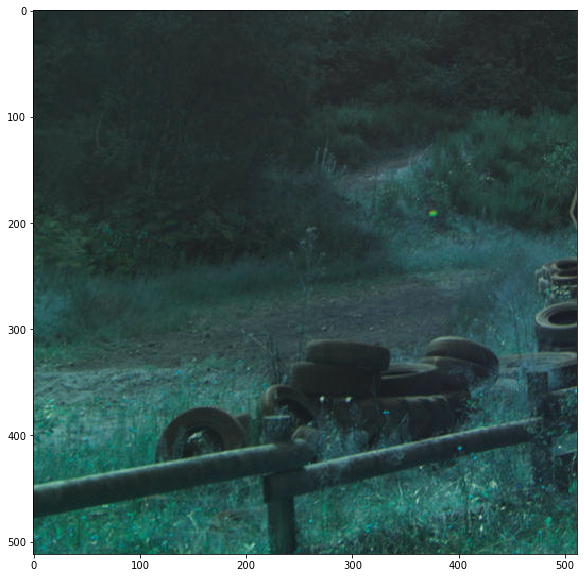

In [53]:
plt.imshow(X[0])

In [54]:
y

array([[1., 0.],
       [0., 1.]])

In [55]:
sr_.compile(loss=keras.losses.binary_crossentropy, 
                    metrics=['accuracy'], optimizer='adadelta')

In [56]:
sr_model_history = sr_.fit_generator(generator=training_generator, 
                                     validation_data=validation_generator, epochs=5)

Train for 3200 steps, validate for 800 steps
Epoch 1/5
3200/3200 [==============================] - 664s 207ms/step - loss: 0.7029 - accuracy: 0.5131 - val_loss: 0.8470 - val_accuracy: 0.5369
Epoch 2/5
3200/3200 [==============================] - 643s 201ms/step - loss: 0.6631 - accuracy: 0.6194 - val_loss: 0.8291 - val_accuracy: 0.5306
Epoch 3/5
3200/3200 [==============================] - 644s 201ms/step - loss: 0.6341 - accuracy: 0.6963 - val_loss: 0.7863 - val_accuracy: 0.5669
Epoch 4/5
3200/3200 [==============================] - 648s 202ms/step - loss: 0.6111 - accuracy: 0.7306 - val_loss: 0.8178 - val_accuracy: 0.5562
Epoch 5/5
3200/3200 [==============================] - 647s 202ms/step - loss: 0.5949 - accuracy: 0.7461 - val_loss: 0.6696 - val_accuracy: 0.6925


In [74]:
sr_.save('Alaska_model.h5')

In [89]:
input_dir = '/kaggle/input/alaska2-image-steganalysis/'
test_imgs = glob.glob(input_dir+'Test/*.jpg')

In [92]:
len(test_imgs)

5000

In [93]:
def generateTestData(id_list, dim=image_size, n_channels=3):
    batch_size = len(id_list)
    X = np.empty((batch_size, *dim, n_channels))

    # Generate data
    for i, ID in enumerate(id_list):
        # Store sample
        X[i,] = get_image_data(ID, dim)
    return X

In [118]:
preds = []

In [119]:
for i in range(0, 5000, 2):
    X = generateTestData(test_imgs[i:i+2])
    y_pred = sr_.predict(X)
    preds.append([test_imgs[i].split('/')[-1], y_pred[0][1]])
    preds.append([test_imgs[i+1].split('/')[-1], y_pred[1][1]])
    if i % 50 == 0:
        print(i)

2
0
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
50
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
100
104
106
108


KeyboardInterrupt: 

In [117]:
len(preds)

8

In [102]:
df = pd.DataFrame(preds, columns=["Id", "Label"])

In [103]:
df.head()

,Id,Label
0,2345.jpg,0.696349
1,3465.jpg,0.546580
2,3776.jpg,0.725039
3,1879.jpg,0.895540
4,4991.jpg,0.511362


In [104]:
df.sort_values(['Id'], inplace=True)

In [105]:
df.head()

,Id,Label
1925,0001.jpg,0.799405
2469,0002.jpg,0.900000
1393,0003.jpg,0.998985
1435,0004.jpg,0.826040
1871,0007.jpg,0.682859


In [106]:
df.to_csv('submission.csv', index=False)

In [107]:
len(df)

2500